In this notebook, we will construct some general bigram transition matrices.

In [1]:
# General Code for Loading Gutenburg Text
# Load list of fiction
import pickle, gzip
import zipfile

# Get a list of fiction
fiction_dict = pickle.load(gzip.open("fiction_list.gz", 'rb'))
ids = list(fiction_dict.keys())
test_book = fiction_dict[ids[0]]

with zipfile.ZipFile(test_book['path'], 'r') as book_zip:
    # We might want to change this to open the one txt file in the zip
    with book_zip.open('{0}.txt'.format(test_book['id'])) as txtfile:
        text = txtfile.read().decode()
        
print("The book is {0} text characters long".format(len(text)))

The book is 306892 text characters long


In [2]:
text[0:20]

"Project Gutenberg's "

In [3]:
type(text)

str

In [4]:
lowercase = text.lower(); lowercase[0:50]

"project gutenberg's the house on the borderland, b"

Importing the character dictionary we built here - https://github.com/benhoyle/patentdata/blob/spacy/patentdata/models/chardict.py.

Amending the character set to have a reduced number.

In [5]:
import string
import unicodedata


def decompose_character(char):
    """ Attempt to return decomposed version of a character
    as list of normalised."""
    try:
        return [
            chr(int(u, 16))
            for u in unicodedata.decomposition(char).split(" ")
            if u and '<' not in u
            ]
    except:
        return None

# Simplying 

class CharDict:
    """ Class to model mapping between characters and integers. """

    def __init__(self):
        """ Initialise and reverse control characters. """
        # Set character set we will use
        self.character_set = (
            string.ascii_lowercase +
            "! ,.?'"
            )
        # Populate rest of dictionary from character set
        self.reverse_dict = {
            i: c for i, c in enumerate(self.character_set, start=0)
            }
        cs_len = len(self.reverse_dict)
        # Reserve special characters    
        self.reverse_dict[cs_len + 0] = "<OOD>" # Out of dict
        self.reverse_dict[cs_len + 1] = "<CAPITAL>" # Out of dict

        self.vocabulary_size = len(self.reverse_dict)

        self.forward_dict = {
            v: k for k, v in self.reverse_dict.items()
            }

        # Create character cleaning dictionary
        self.char_cleaner = dict()
        self.char_cleaner['”'] = "'"
        self.char_cleaner['“'] = "'"
        self.char_cleaner['\u2003'] = ' '
        self.char_cleaner['\ue89e'] = ' '
        self.char_cleaner['\u2062'] = ' '
        self.char_cleaner['\ue8a0'] = ' '
        self.char_cleaner['−'] = '-'
        self.char_cleaner['—'] = '-'
        self.char_cleaner['′'] = "'"
        self.char_cleaner['‘'] = "'"
        self.char_cleaner['’'] = "'"
        self.char_cleaner['×'] = '*'
        self.char_cleaner['⁄'] = '/'

    def int2char(self, integer):
        """ Convert an integer into a character using the object. """
        return self.reverse_dict[integer]

    def clean_char(character):
        if character in self.char_cleaner.keys():
            return self.char_cleaner[character]
        else:
            return character

    def text2int(self, text):
        """ Convert a block of text into an integer. """

        integer_list = list()
        for character in text:
            # Perform mapping for commonly occuring characters
            if character in self.char_cleaner.keys():
                character = self.char_cleaner[character]

            # If character is in mapping dictionary add int to list
            if character in self.forward_dict.keys():
                integer_list.append(self.forward_dict[character])
            elif character in string.ascii_uppercase:
                # If uppercase
                integer_list.append(self.forward_dict["<CAPITAL>"])
                integer_list.append(self.forward_dict[character.lower()])
            else:
                replacement_chars = decompose_character(character)
                if replacement_chars:
                    integer_list += self.text2int("".join(replacement_chars))
                else:
                    integer_list.append(self.forward_dict["<OOD>"])
        return integer_list

    def intlist2text(self, int_list):
        """ Convert a list of integers back into text. """
        text = str()
        capitalise = False
        for i in int_list:
            char = self.reverse_dict[i]
            if char == "<CAPITAL>":
                capitalise = True
            else:
                if capitalise == True:
                    char = char.upper()
                text += char
                capitalise = False
        return text

    # We need to add a method that returns a one-hot encoding


In [6]:
chardict = CharDict()

In [7]:
chardict.text2int(lowercase[0:20])

[15, 17, 14, 9, 4, 2, 19, 27, 6, 20, 19, 4, 13, 1, 4, 17, 6, 31, 18, 27]

In [8]:
chardict.reverse_dict.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

In [9]:
integers = chardict.text2int(lowercase)

In [10]:
len(integers)

306892

To determine a bigram transition matrix, we convert each integer into a one-hot representation. Then we create a transition matrix the same length as the keys. Then we simply increment mat[i, j] with i and j as the two consecutive characters.

In [11]:
chardict.vocabulary_size

34

In [12]:
type(integers[9])

int

In [13]:
import numpy as np

In [14]:
# Define transition matrix
num_ints = chardict.vocabulary_size
trans_mat = np.zeros(shape=(num_ints, num_ints))
# For each pair of characters
for char_1, char_2 in zip(integers[0:-1], integers[1:]):
    trans_mat[char_1, char_2] += 1

In [15]:
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


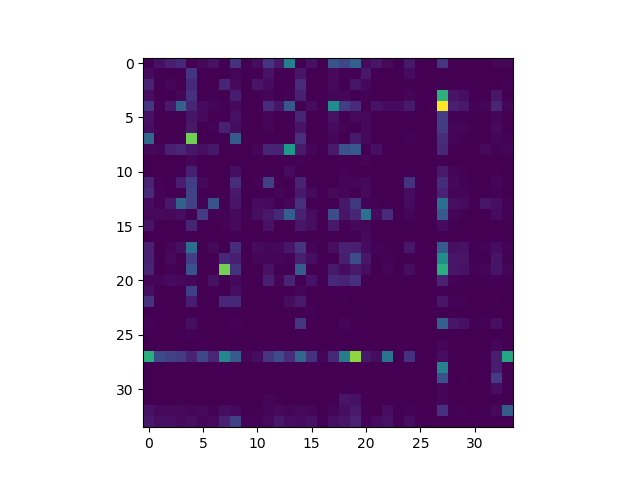

In [16]:
%matplotlib notebook
plt.imshow(trans_mat)

This shows we can probably ditch many of the characters initially.

We can maybe keep: "!,? \<space\>.

In [17]:
chardict.character_set

"abcdefghijklmnopqrstuvwxyz! ,.?'"

In [18]:
trans_mat/trans_mat.max()

array([[2.36658384e-04, 4.59117264e-02, 9.14684653e-02, ...,
        1.18329192e-04, 1.36078571e-02, 0.00000000e+00],
       [2.43758135e-02, 3.78653414e-03, 2.36658384e-04, ...,
        0.00000000e+00, 3.54987575e-04, 0.00000000e+00],
       [6.89859188e-02, 0.00000000e+00, 1.36078571e-02, ...,
        0.00000000e+00, 1.30162111e-03, 0.00000000e+00],
       ...,
       [3.54987575e-04, 2.36658384e-04, 8.28304343e-04, ...,
        0.00000000e+00, 8.28304343e-04, 0.00000000e+00],
       [6.69743226e-02, 2.39024967e-02, 2.79256893e-02, ...,
        2.01159626e-03, 8.98710212e-01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [19]:
integer_mat = ((trans_mat/trans_mat.max())*255).astype(np.uint8)

In [20]:
plt.imshow(integer_mat)

In [21]:
np.set_printoptions(threshold=np.inf)
integer_mat

array([[  0,  11,  23,  35,   0,   4,  11,   0,  19,   0,   6,  32,  16,
        101,   0,  11,   0,  59,  63,  79,   3,  13,   9,   0,  14,   1,
          0,  41,   0,   0,   0,   0,   3,   0],
       [  6,   0,   0,   0,  33,   0,   0,   0,   2,   0,   0,  15,   0,
          0,   9,   0,   0,   7,   1,   1,  12,   0,   0,   0,   5,   0,
          0,   0,   0,   0,   0,   0,   0,   0],
       [ 17,   0,   3,   0,  33,   0,   0,  21,   6,   0,  11,   7,   0,
          0,  30,   0,   0,  10,   0,  11,   5,   0,   0,   0,   0,   0,
          0,   1,   0,   0,   0,   0,   0,   0],
       [  9,   0,   0,   5,  34,   0,   2,   0,  21,   0,   0,   4,   0,
          0,  18,   0,   0,   4,   4,   0,   5,   0,   0,   0,   3,   0,
          0, 157,  28,  10,   0,   0,  16,   0],
       [ 56,   1,  16,  90,  34,   7,   3,   1,   6,   0,   0,  25,  18,
         82,   1,  11,   0, 100,  46,  20,   0,  11,   8,   5,   7,   0,
          0, 240,  34,  16,   0,   0,  29,   0],
       [ 10,   0,   0,   

In [22]:
integer_mat_16 = ((trans_mat/trans_mat.max())*(2**16)).astype(np.uint16)

In [23]:
print(integer_mat_16)

[[   15  3008  5994  9135    93  1248  2869   155  4970     0  1698  8476
   4288 26149   255  3055     0 15245 16393 20395   891  3543  2427    85
   3714   480     7 10608   100    93     7     7   891     0]
 [ 1597   248    15    38  8545     0     0     7   566    69     0  4016
     31    15  2473     0     0  1822   302   310  3264     7     0     0
   1318     0     0   116    31    77     0     0    23     0]
 [ 4521     0   891     0  8483     0     0  5397  1550     0  2977  2047
      0     0  7739     0    15  2644     0  3055  1450     0     0     0
    131     0     0   418    23    15     0     0    85     0]
 [ 2535     0    46  1302  8972    62   535     0  5606    15     7  1046
     23   124  4815     0     0  1147  1039    54  1326    62   131     0
    860     0    62 40363  7429  2822    31    54  4241     0]
 [14602   387  4218 23318  8902  2000   930   426  1613     0   116  6459
   4769 21124   341  3078   170 25846 11857  5234    31  3024  2062  1519
   1861 

In [24]:
plt.imshow(integer_mat_16)

# Process All Books

Now let's loop through all the books and build a 16 bit transition matrix.

In [25]:
# Define transition matrix
num_ints = chardict.vocabulary_size
trans_mat = np.zeros(shape=(num_ints, num_ints))

for book_id in ids:
    test_book = fiction_dict[book_id]

    try:
        # Get text
        with zipfile.ZipFile(test_book['path'], 'r') as book_zip:
            # We might want to change this to open the one txt file in the zip
            with book_zip.open('{0}.txt'.format(test_book['id'])) as txtfile:
                text = txtfile.read().decode()
                
        temp_trans_mat = np.zeros(shape=(num_ints, num_ints))
        integers = chardict.text2int(text)
        # For each pair of characters
        for char_1, char_2 in zip(integers[0:-1], integers[1:]):
            temp_trans_mat[char_1, char_2] += 1
            
        integer_trans_mat = ((temp_trans_mat/temp_trans_mat.max())*(2**16)).astype(np.uint16)
        
        # Average
        trans_mat = trans_mat//2 + integer_trans_mat//2
    except Exception as e: 
        print(f"An error occurred with book {test_book['title']}")
        print(f"Error: {e}")

An error occurred with book The Secret of the Tower
Error: "There is no item named '10057.txt' in the archive"
An error occurred with book Aunt Jane's Nieces on Vacation
Error: 'utf-8' codec can't decode byte 0xe9 in position 280951: invalid continuation byte
An error occurred with book Gunman's Reckoning
Error: "There is no item named '10066.txt' in the archive"
An error occurred with book A Little Boy Lost
Error: "There is no item named '10101.txt' in the archive"
An error occurred with book The Sowers
Error: "There is no item named '10132.txt' in the archive"
An error occurred with book Maezli: A Story of the Swiss Valleys
Error: "There is no item named '10142.txt' in the archive"
An error occurred with book The Water-Babies
Error: 'path'
An error occurred with book Wolves of the Sea: Being a Tale of the Colonies from the Manuscript of One Geoffry Carlyle, Seaman, Narrating Certain Strange Adventures Which Befell Him Aboard the Pirate Craft "Namur"
Error: "There is no item named '10

An error occurred with book The Aeroplane Boys on the Wing: Or, Aeroplane Chums in the Tropics
Error: "There is no item named '10698.txt' in the archive"
An error occurred with book Men, Women, and Ghosts
Error: "There is no item named '10744.txt' in the archive"
An error occurred with book The World's Greatest Books — Volume 03 — Fiction
Error: "There is no item named '10748.txt' in the archive"
An error occurred with book The Sea-Wolf
Error: 'path'
An error occurred with book The Strength of the Strong
Error: 'path'
An error occurred with book The Moving Picture Boys at Panama; Or, Stirring Adventures Along the Great Canal
Error: "There is no item named '10776.txt' in the archive"
An error occurred with book Probable Sons
Error: "There is no item named '10777.txt' in the archive"
An error occurred with book The Prose Marmion: A Tale of the Scottish Border
Error: "There is no item named '10778.txt' in the archive"
An error occurred with book Happy Little Edward: And His Pleasant Ride 

An error occurred with book The Precipice: A Novel
Error: 'utf-8' codec can't decode byte 0xb8 in position 33744: invalid start byte
An error occurred with book Vandemark's Folly
Error: 'utf-8' codec can't decode byte 0xe8 in position 424840: invalid continuation byte
An error occurred with book Odd Craft, Complete
Error: 'path'
An error occurred with book Pink and White Tyranny: A Society Novel
Error: 'path'
An error occurred with book The House of a Thousand Candles
Error: 'path'
An error occurred with book The Heritage of the Desert: A Novel
Error: 'utf-8' codec can't decode byte 0xa0 in position 696: invalid start byte
An error occurred with book Marriage
Error: 'path'
An error occurred with book The Boy Allies in Great Peril; Or, With the Italian Army in the Alps
Error: 'utf-8' codec can't decode byte 0xe9 in position 11659: invalid continuation byte
An error occurred with book The Tale of Peter Rabbit
Error: 'path'
An error occurred with book Tokyo to Tijuana: Gabriele Departing 

An error occurred with book The Marvelous Land Of Oz
Error: 'path'
An error occurred with book Other People's Money
Error: 'path'
An error occurred with book El Dorado: An Adventure of the Scarlet Pimpernel
Error: 'path'
An error occurred with book Halil the Pedlar: A Tale of Old Stambul
Error: 'utf-8' codec can't decode byte 0xf3 in position 51: invalid continuation byte
An error occurred with book The Man Who Could Not Lose
Error: 'path'
An error occurred with book The American
Error: 'path'
An error occurred with book Blackbeard; Or, The Pirate of Roanoke.
Error: 'utf-8' codec can't decode byte 0x8a in position 593: invalid start byte
An error occurred with book Someone Comes to Town, Someone Leaves Town
Error: 'path'
An error occurred with book The Prince and the Pauper
Error: 'path'
An error occurred with book Melbourne House
Error: 'path'
An error occurred with book Daisy
Error: 'path'
An error occurred with book Daisy in the Field
Error: 'path'
An error occurred with book The Wi

An error occurred with book The Secret Garden
Error: 'path'
An error occurred with book The Sign of the Four
Error: 'path'
An error occurred with book The Parasite
Error: 'path'
An error occurred with book The Reluctant Dragon
Error: 'path'
An error occurred with book The Vicar of Wakefield
Error: 'path'
An error occurred with book The Wisdom of Father Brown
Error: 'path'
An error occurred with book Eingeschneit: Eine Studentengeschichte
Error: 'path'
An error occurred with book Short Cruises
Error: 'path'
An error occurred with book Light Freights
Error: 'path'
An error occurred with book A Master Of Craft
Error: 'path'
An error occurred with book The Dark Flower
Error: 'path'
An error occurred with book Salthaven
Error: 'path'
An error occurred with book Sea Urchins
Error: 'path'
An error occurred with book Embarrassments
Error: 'path'
An error occurred with book The Son of Monte-Cristo, Volume I
Error: 'utf-8' codec can't decode byte 0xe8 in position 92: invalid continuation byte
An

An error occurred with book The Forsyte Saga, Volume I.: The Man Of Property
Error: 'path'
An error occurred with book The Day's Work - Volume 1
Error: 'path'
An error occurred with book An Apostate: Nawin of Thais
Error: 'path'
An error occurred with book More Cargoes: 1897
Error: 'path'
An error occurred with book The Mission of Janice Day
Error: 'utf-8' codec can't decode byte 0xfa in position 635: invalid start byte
An error occurred with book The Forsyte Saga, Volume II.: Indian Summer of a Forsyte; In Chancery
Error: 'path'
An error occurred with book The Forsyte Saga, Volume III.: Awakening; To Let
Error: 'path'
An error occurred with book War and Peace
Error: 'path'
An error occurred with book The Pigeon Pie
Error: 'path'
An error occurred with book The Story of Doctor Doolittle
Error: 'path'
An error occurred with book The Adventures of Tom Sawyer
Error: 'path'
An error occurred with book The Dog Crusoe and His Master
Error: 'path'
An error occurred with book A Girl of the Lim

An error occurred with book Spawn of the Comet
Error: 'utf-8' codec can't decode byte 0x93 in position 711: invalid start byte
An error occurred with book With the Night Mail: A Story of 2000 A.D.: (Together with extracts from the comtemporary magazine in which it appeared)
Error: 'utf-8' codec can't decode byte 0xb6 in position 79418: invalid start byte
An error occurred with book The Captain of the Polestar, and Other Tales
Error: 'utf-8' codec can't decode byte 0xfc in position 147094: invalid start byte
An error occurred with book The Midnight Queen
Error: 'utf-8' codec can't decode byte 0xe9 in position 282415: invalid continuation byte
An error occurred with book Is He Popenjoy?
Error: 'utf-8' codec can't decode byte 0xa3 in position 123202: invalid start byte
An error occurred with book The Romantic Adventures of a Milkmaid
Error: 'path'
An error occurred with book Little Brother
Error: 'path'
An error occurred with book An Open-Eyed Conspiracy; An Idyl of Saratoga
Error: 'path'

An error occurred with book Anna of the Five Towns
Error: 'path'
An error occurred with book La Mere Bauche: From Tales of All Countries
Error: 'path'
An error occurred with book The Sword of Honor; or, The Foundation of the French Republic: A Tale of The French Revolution
Error: 'utf-8' codec can't decode byte 0xba in position 373067: invalid start byte
An error occurred with book The Lost Mountain: A Tale of Sonora
Error: 'utf-8' codec can't decode byte 0xc9 in position 412: invalid continuation byte
An error occurred with book The Messenger
Error: 'utf-8' codec can't decode byte 0xe9 in position 92: invalid continuation byte
An error occurred with book Artist and Model (The Divorced Princess)
Error: 'utf-8' codec can't decode byte 0xe9 in position 53: invalid continuation byte
An error occurred with book The Jungle Book
Error: 'utf-8' codec can't decode byte 0xfe in position 278625: invalid start byte
An error occurred with book The Mysterious Sketch
Error: 'path'
An error occurred 

An error occurred with book The Mystery of the Lost Dauphin (Louis XVII)
Error: 'utf-8' codec can't decode byte 0xe1 in position 82: invalid continuation byte
An error occurred with book The Milkmaid of Montfermeil (Novels of Paul de Kock Volume XX)
Error: 'path'
An error occurred with book Bound to Succeed; or, Mail Order Frank's Chances
Error: 'path'
An error occurred with book Oak Openings
Error: 'utf-8' codec can't decode byte 0x97 in position 334191: invalid start byte
An error occurred with book A Portrait of the Artist as a Young Man
Error: 'path'
An error occurred with book Vathek; An Arabian Tale
Error: 'path'
An error occurred with book Women in Love
Error: 'path'
An error occurred with book Tales and Fantasies
Error: 'path'
An error occurred with book Ragged Lady — Complete
Error: 'path'
An error occurred with book The Motor Boys Overland; Or, A Long Trip for Fun and Fortune
Error: 'utf-8' codec can't decode byte 0x93 in position 3986: invalid start byte
An error occurred wi

An error occurred with book Hesper, the Home-Spirit: A simple story of household labor and love
Error: 'path'
An error occurred with book Moral Tales
Error: 'path'
An error occurred with book Old Fort Garland
Error: 'path'
An error occurred with book Ulric the Jarl: A Story of the Penitent Thief
Error: 'path'
An error occurred with book The Bishop's Apron: A study in the origins of a great family
Error: 'path'
An error occurred with book Elsket and Other Stories
Error: 'path'
An error occurred with book Aunt Crete's Emancipation
Error: 'path'
An error occurred with book Lillian Morris, and Other Stories
Error: 'path'
An error occurred with book Oliver Twist, Vol. 1 (of 3)
Error: 'path'
An error occurred with book Oliver Twist, Vol. 2 (of 3)
Error: 'path'
An error occurred with book Oliver Twist, Vol. 3 (of 3)
Error: 'path'
An error occurred with book The Forest Farm: Tales of the Austrian Tyrol
Error: 'path'
An error occurred with book The Posthumous Papers of the Pickwick Club, v. 1 (

An error occurred with book The Fall of a Nation: A Sequel to the Birth of a Nation
Error: 'path'
An error occurred with book Back o' the Moon, and other stories
Error: 'path'
An error occurred with book The Green Goddess
Error: 'path'
An error occurred with book The King Behind the King
Error: 'path'
An error occurred with book The Heir to Grand-Pré
Error: 'path'
An error occurred with book The Secret Victory
Error: 'path'
An error occurred with book The Mystery of the Iron Box: A Ken Holt Mystery
Error: 'path'
An error occurred with book Bennie Ben Cree: Being the Story of His Adventure to Southward in the Year '62
Error: 'path'
An error occurred with book The Boy Scouts of the Life Saving Crew
Error: 'path'
An error occurred with book The Children of the Valley
Error: 'path'
An error occurred with book Poganuc People: Their Loves and Lives
Error: 'path'
An error occurred with book Hester: A Story of Contemporary Life, Volume 1 (of 3)
Error: 'path'
An error occurred with book Hester:

An error occurred with book The Story of Captain, the Horse with the Human Brain
Error: 'path'
An error occurred with book A Girl of the North: A Story of London and Canada
Error: 'path'
An error occurred with book Frank Armstrong, Drop Kicker
Error: 'path'
An error occurred with book A Balloon Ascension at Midnight
Error: 'path'
An error occurred with book The Brown Owl: A Fairy Story
Error: 'path'
An error occurred with book Jack, the Fire Dog
Error: 'path'
An error occurred with book Little Pitchers: Flaxie Frizzle Stories
Error: 'path'
An error occurred with book The Motor Boat Club off Long Island; or, A Daring Marine Game at Racing Speed
Error: 'path'
An error occurred with book The Fantasy Fan, March, 1934: The Fans' Own Magazine
Error: 'path'
An error occurred with book Rough Beast
Error: 'path'
An error occurred with book The Mystery of the Ravenspurs: A Romance and Detective Story of Thibet and England
Error: 'path'
An error occurred with book Sea-gift: A Novel
Error: 'path'


An error occurred with book Leah Mordecai: A Novel
Error: 'utf-8' codec can't decode byte 0x91 in position 5722: invalid start byte
An error occurred with book Won in the Ninth: The first of a series of stories for boys on sports to be known as The Matty Books
Error: 'path'
An error occurred with book The Duke's Prize; a Story of Art and Heart in Florence
Error: 'utf-8' codec can't decode byte 0x92 in position 331355: invalid start byte
An error occurred with book Little Lord Fauntleroy [abridged]: Für den Schulgebrauch bearbeitet
Error: 'path'
An error occurred with book The Heart's Secret; Or, the Fortunes of a Soldier: a Story of Love and the Low Latitudes.
Error: 'utf-8' codec can't decode byte 0x91 in position 59471: invalid start byte
An error occurred with book Justice in the By-Ways, a Tale of Life
Error: 'utf-8' codec can't decode byte 0x88 in position 96383: invalid start byte
An error occurred with book In African Forest and Jungle
Error: 'path'
An error occurred with book T

An error occurred with book Dave Dashaway and His Giant Airship; or, A Marvellous Trip Across the Atlantic
Error: 'path'
An error occurred with book The Forlorn Hope: A Tale of Old Chelsea
Error: 'path'
An error occurred with book Motor Matt Makes Good; or, Another Victory For the Motor Boys
Error: 'path'
An error occurred with book The Marryers: A History Gathered from a Brief of the Honorable Socrates Potter
Error: 'path'
An error occurred with book The Paper Cap: A Story of Love and Labor
Error: 'path'
An error occurred with book The Red Lady
Error: 'path'
An error occurred with book The River Motor Boat Boys on the Amazon; Or, The Secret of Cloud Island
Error: 'path'
An error occurred with book The Dwindling Years
Error: 'path'
An error occurred with book Jessica's First Prayer; and, Jessica's Mother
Error: 'path'
An error occurred with book Grace Harlowe's Overland Riders on the Old Apache Trail
Error: 'path'
An error occurred with book Julius LeVallon: An Episode
Error: 'path'
An

An error occurred with book The Green Odyssey
Error: 'path'
An error occurred with book A Sub. of the R.N.R.: A Story of the Great War
Error: 'path'
An error occurred with book A Thousand Degrees Below Zero
Error: 'path'
An error occurred with book Four in Camp: A Story of Summer Adventures in the New Hampshire Woods
Error: 'path'
An error occurred with book Flute and Violin, and Other Kentucky Tales and Romances
Error: 'path'
An error occurred with book The Dark Frigate
Error: 'path'
An error occurred with book The Boy Scouts at the Canadian Border
Error: 'path'
An error occurred with book The Phantom Friend: A Judy Bolton Mystery
Error: 'path'
An error occurred with book Katherine Lauderdale; Vol. 1 of 2
Error: 'path'
An error occurred with book The Pillar of Fire; or, Israel in Bondage
Error: 'path'
An error occurred with book My Short Story Book
Error: 'path'
An error occurred with book The Silver Menace
Error: 'path'
An error occurred with book The Young Vigilantes: A Story of Cal

An error occurred with book The Last of the Mortimers: A Story in Two Voices
Error: 'path'
An error occurred with book Grace O'Malley, Princess and Pirate
Error: 'path'
An error occurred with book The Mysteries of London, v. 2/4
Error: 'path'
An error occurred with book The Pilot and the Bushman
Error: 'path'
An error occurred with book A Dog Day; or, The Angel in the House
Error: 'path'
An error occurred with book In Bad Company, and other stories
Error: 'path'
An error occurred with book The Prisoner of the Mill; or, Captain Hayward's "Body Guard"
Error: 'path'
An error occurred with book Woodcraft Boys at Sunset Island
Error: 'path'
An error occurred with book I Am a Nucleus
Error: 'path'
An error occurred with book To the Fore with the Tanks!
Error: 'path'
An error occurred with book Motor Matt's Reverse; or, Caught in a Losing Cause
Error: 'path'
An error occurred with book Agnes Sorel: A Novel
Error: 'path'
An error occurred with book Patty's Fortune
Error: 'path'
An error occurr

An error occurred with book The Royal End: A Romance
Error: 'path'
An error occurred with book Sandburrs
Error: 'path'
An error occurred with book Simeon Tetlow's Shadow
Error: 'path'
An error occurred with book The Sin That Was His
Error: 'path'
An error occurred with book The Trufflers: A Story
Error: 'path'
An error occurred with book Two Women or One? From the Mss. of Dr. Leonard Benary
Error: 'path'
An error occurred with book Webster—Man's Man
Error: 'path'
An error occurred with book Well, After All--
Error: 'path'
An error occurred with book The Woman in the Alcove
Error: 'path'
An error occurred with book The Adventures of Squirrel Fluffytail: A Picture Story-Book for Children
Error: 'path'
An error occurred with book My Pretty Maid; or, Liane Lester
Error: 'path'
An error occurred with book Mitchelhurst Place: A Novel. Vol. 2 (of 2)
Error: 'path'
An error occurred with book A Boy's Fortune; Or, The Strange Adventures of Ben Baker
Error: 'utf-8' codec can't decode byte 0xe9 in

An error occurred with book The Two Marys
Error: 'path'
An error occurred with book Adventures of a Telegraph Boy; or, "Number 91"
Error: 'path'
An error occurred with book The Decameron (Day 1 to Day 5): Containing an hundred pleasant Novels
Error: 'path'
An error occurred with book The Decameron (Day 6 to Day 10): Containing an hundred pleasant Novels
Error: 'path'
An error occurred with book Marjorie Dean at Hamilton Arms
Error: 'path'
An error occurred with book The Third Officer: A Present-day Pirate Story
Error: 'path'
An error occurred with book The Dreadnought Boys on Aero Service
Error: 'path'
An error occurred with book A Lear of the Steppes, etc.
Error: 'path'
An error occurred with book Who Was Paul Grayson?
Error: 'path'
An error occurred with book Traitor and True: A Romance
Error: 'path'
An error occurred with book Hear Me, Pilate!
Error: 'path'
An error occurred with book The Chinese Coat
Error: 'path'
An error occurred with book Happy Island: A New "Uncle William" Stor

An error occurred with book A Sister to Evangeline: Being the Story of Yvonne de Lamourie, and how she went into exile with the villagers of Grand Pré
Error: 'path'
An error occurred with book Goslings
Error: 'path'
An error occurred with book Marjorie Dean Macy
Error: 'path'
An error occurred with book Heart and Cross
Error: 'path'
An error occurred with book Mothers to Men
Error: 'path'
An error occurred with book Kate Vernon: A Tale. Vol. 3 (of 3)
Error: 'path'
An error occurred with book The Story of the Gravelys: A Tale for Girls
Error: 'path'
An error occurred with book Among the River Pirates: A Skippy Dare Mystery Story
Error: 'path'
An error occurred with book The House of Armour
Error: 'path'
An error occurred with book The Motor Boys Bound for Home; or, Ned, Bob and Jerry on the Wrecked Troopship
Error: 'path'
An error occurred with book Jessie Trim
Error: 'path'
An error occurred with book The Mercer Boys in the Ghost Patrol
Error: 'path'
An error occurred with book The Coi

An error occurred with book Many Cargoes
Error: 'path'
An error occurred with book The Pickwick Papers
Error: 'utf-8' codec can't decode byte 0xa0 in position 768: invalid start byte
An error occurred with book Master Humphrey's Clock
Error: 'path'
An error occurred with book Catriona
Error: 'path'
An error occurred with book Thomas Wingfold, Curate V1
Error: 'path'
An error occurred with book Clara Hopgood
Error: 'path'
An error occurred with book In Kedar's Tents
Error: 'path'
An error occurred with book The Little Lady of Lagunitas: A Franco-Californian Romance
Error: 'path'
An error occurred with book Stories by English Authors: Ireland
Error: 'utf-8' codec can't decode byte 0xea in position 180459: invalid continuation byte
An error occurred with book The Roots of the Mountains: Wherein Is Told Somewhat of the Lives of the Men of Burgdale, Their Friends, Their Neighbours, Their Foemen, and Their Fellows in Arms
Error: 'path'
An error occurred with book Nature and Human Nature
Erro

An error occurred with book The Red One
Error: 'path'
An error occurred with book The Gathering of Brother Hilarius
Error: 'path'
An error occurred with book Mrs. Day's Daughters
Error: 'path'
An error occurred with book The Wouldbegoods: Being the Further Adventures of the Treasure Seekers
Error: 'path'
An error occurred with book Jean-Christophe Journey's End
Error: 'path'
An error occurred with book Lying Prophets: A Novel
Error: 'path'
An error occurred with book Jean-Christophe, Volume I
Error: 'path'
An error occurred with book A Sentimental Journey Through France and Italy
Error: 'path'
An error occurred with book A Fountain Sealed
Error: 'path'
An error occurred with book Holiday Romance
Error: 'path'
An error occurred with book George Silverman's Explanation
Error: 'path'
An error occurred with book The Possessed (The Devils)
Error: 'path'
An error occurred with book The Misses Mallett (The Bridge Dividing)
Error: 'path'
An error occurred with book The Girls of Central High Ai

An error occurred with book Personal Recollections of Joan of Arc — Volume 01
Error: 'path'
An error occurred with book Personal Recollections of Joan of Arc — Volume 02
Error: 'path'
An error occurred with book The $30,000 Bequest, and Other Stories
Error: 'path'
An error occurred with book Extract from Captain Stormfield's Visit to Heaven
Error: 'path'
An error occurred with book Adventures of Huckleberry Finn
Error: 'path'
An error occurred with book A Horse's Tale
Error: 'path'
An error occurred with book The American Claimant
Error: 'path'
An error occurred with book The Facts Concerning the Recent Carnival of Crime in Connecticut
Error: 'path'
An error occurred with book A Dog's Tale
Error: 'path'
An error occurred with book Those Extraordinary Twins
Error: 'path'
An error occurred with book Goldsmith's Friend Abroad Again
Error: 'path'
An error occurred with book The Gilded Age
Error: 'path'
An error occurred with book The Man That Corrupted Hadleyburg and Other Stories
Error: '

An error occurred with book Daniel Deronda
Error: 'path'
An error occurred with book Adam Bede
Error: 'path'
An error occurred with book Brother Jacob
Error: 'path'
An error occurred with book The Lifted Veil
Error: 'path'
An error occurred with book The Mill on the Floss
Error: 'path'
An error occurred with book Silas Marner
Error: 'path'
An error occurred with book Of Captain Mission
Error: 'path'
An error occurred with book The Consolidator
Error: 'path'
An error occurred with book The Life, Adventures and Piracies of the Famous Captain Singleton
Error: 'path'
An error occurred with book Dickory Cronke
Error: 'path'
An error occurred with book A Journal of the Plague Year
Error: 'path'
An error occurred with book Moll Flanders
Error: 'path'
An error occurred with book The Further Adventures of Robinson Crusoe
Error: 'path'
An error occurred with book Robinson Crusoe
Error: 'path'
An error occurred with book Three Ghost Stories
Error: 'path'
An error occurred with book A Message from

In [26]:
print(trans_mat)

[[0.0000e+00 1.9800e+03 3.8400e+03 5.3300e+03 3.6000e+01 9.3900e+02
  2.0670e+03 1.0100e+02 6.5770e+03 1.3000e+01 1.5140e+03 6.9420e+03
  3.2190e+03 1.9872e+04 2.5000e+01 2.0730e+03 0.0000e+00 1.1726e+04
  9.7980e+03 1.4243e+04 1.3000e+03 2.8390e+03 1.1420e+03 8.2000e+01
  3.1590e+03 2.9700e+02 3.4000e+01 7.1050e+03 1.6000e+02 1.2000e+02
  8.0000e+00 3.6000e+01 7.1500e+02 6.8500e+02]
 [1.3880e+03 1.9000e+02 0.0000e+00 5.0000e+00 6.9900e+03 0.0000e+00
  1.0000e+00 1.0000e+00 5.5900e+02 9.5000e+01 0.0000e+00 2.1730e+03
  5.0000e+00 1.3000e+01 2.7880e+03 1.0000e+00 0.0000e+00 1.1860e+03
  2.5200e+02 2.0500e+02 2.9140e+03 1.7000e+01 0.0000e+00 0.0000e+00
  1.3030e+03 0.0000e+00 1.0000e+00 1.1700e+02 3.1000e+01 3.5000e+01
  3.0000e+00 2.0000e+00 2.6000e+01 1.3600e+02]
 [4.5000e+03 0.0000e+00 5.4700e+02 1.0000e+00 5.3510e+03 0.0000e+00
  0.0000e+00 4.8380e+03 1.2520e+03 0.0000e+00 2.3830e+03 1.3730e+03
  1.0000e+00 0.0000e+00 5.4540e+03 0.0000e+00 5.5000e+01 1.0250e+03
  6.3000e+01 2.5410e+0

In [27]:
np.save("trans_mat.npy", trans_mat)

<IPython.core.display.Javascript object>


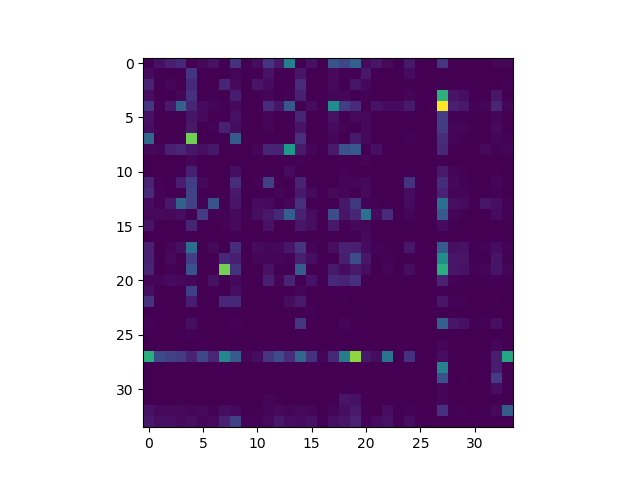

In [29]:
plt.imshow(trans_mat)

In [31]:
import pandas as pd

df = pd.DataFrame(trans_mat)
filepath = "transmat.xlsx"
df.to_excel(filepath, index=False)